# ECE239AS Project

#### Load the dataset

In [1]:
from useful.utils_rnn import *
train_loader, test_loader,val_loader = loader()(path='./project_datasets/A01T_slice.mat',
                                                batch_size= 20,
                                                num_test = 50,
                                                num_validation = 38)

/Users/shuangyu/anaconda3/envs/pytorch/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


X_shape (288, 22, 1000)
y_shape (1, 1000)
nan exists on row 56,and be deleted
Train data shape:  (199, 22, 1000)
Train labels shape:  (199,)
test data shape:  (50, 22, 1000)
test labels shape:  (50,)
Validation data shape:  (38, 22, 1000)
Validation labels shape:  (38,)


In [2]:
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

criteria = F.cross_entropy

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target).long()
        
        # optimizer.zero_grad()
        model.zero_grad()
        
        # Dim required by LSTM (time, )
        data_t = torch.transpose(data, dim0=1, dim1=2)
        output = model(data_t)
        loss = criteria(output, target)
        loss.backward(retain_graph=True)
        optimizer.step()
        if batch_idx % 5 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))
    

def test(test_loader=test_loader, mode = 'val'):
    # train mode to get the train accuracy 
    # val mode to get the validation accuracy
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target).long()
        data_t = torch.transpose(data, dim0=1, dim1=2)
        output = model(data_t)
        test_loss += criteria(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    if mode == 'train':
        print('train loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
        

    else:
        print('\nvalidation loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    
    return [test_loss,correct / len(test_loader.dataset)]

####  1 layer LSTM + 1 layer fc

In [3]:
class RNN_LSTM(nn.Module):
    def __init__(self, input_size=22, hidden_size=64, num_layers=1, num_classes=4):
        super(RNN_LSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Dim: batch_size, time, feature
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True,dropout = 0.7)
        self.fc = nn.Sequential(
                    nn.Linear(hidden_size, num_classes),
                    
        )
        

    def forward(self, x):

        # Forward propagate RNN
        out, _ = self.lstm(x)

        # Decode hidden state of last time step
        out = self.fc(out[:, -1, :])
        return out
    
    
    
import torch.autograd as autograd
import matplotlib.pyplot as plt

model = RNN_LSTM()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, betas=(0.9,0.999), eps=1e-08, weight_decay=0.005)
stats = {}
stats['train'] = []
stats['val']  = []

epoches = range(30)
for epoch in epoches:
    train(epoch)
    stats['train'].append(test(train_loader,mode = 'train'))
    stats['val'].append(test(val_loader,mode = 'val'))
    
    if epoch == epoches[-1]:
        test(test_loader,mode = 'test')

# draw a figure for this layer
stats['val']  = np.array(stats['val'])
stats['train'] = np.array(stats['train'])

fig, ax = plt.subplots(1, 2,figsize = (8,4))
ax[0].plot(epoches,stats['val'][:,0],epoches,stats['train'][:,0])

ax[0].legend(['validation','train'])
ax[0].set_title('loss')

ax[1].plot(epoches,stats['val'][:,1],epoches,stats['train'][:,1])

ax[1].legend(['validation','train'])
ax[1].set_title('accuracy')

Train Epoch: 0 [0/199 (0%)]	Loss: 1.380970
Train Epoch: 0 [100/199 (50%)]	Loss: 1.430069
train loss: 1.3581, Accuracy: 60/199 (30%)

validation loss: 1.4340, Accuracy: 8/38 (21%)

Train Epoch: 1 [0/199 (0%)]	Loss: 1.396243
Train Epoch: 1 [100/199 (50%)]	Loss: 1.422194
train loss: 1.3487, Accuracy: 66/199 (33%)

validation loss: 1.4495, Accuracy: 8/38 (21%)

Train Epoch: 2 [0/199 (0%)]	Loss: 1.386035
Train Epoch: 2 [100/199 (50%)]	Loss: 1.362783
train loss: 1.3361, Accuracy: 70/199 (35%)

validation loss: 1.4363, Accuracy: 7/38 (18%)

Train Epoch: 3 [0/199 (0%)]	Loss: 1.316497
Train Epoch: 3 [100/199 (50%)]	Loss: 1.308788
train loss: 1.3233, Accuracy: 76/199 (38%)

validation loss: 1.4445, Accuracy: 11/38 (29%)

Train Epoch: 4 [0/199 (0%)]	Loss: 1.350053
Train Epoch: 4 [100/199 (50%)]	Loss: 1.335914
train loss: 1.3116, Accuracy: 79/199 (40%)

validation loss: 1.4718, Accuracy: 7/38 (18%)

Train Epoch: 5 [0/199 (0%)]	Loss: 1.262463
Train Epoch: 5 [100/199 (50%)]	Loss: 1.275878
train loss

Text(0.5,1,'accuracy')

## 2 layer LSTM + 1 layer fc

Train Epoch: 0 [0/199 (0%)]	Loss: 1.389083
Train Epoch: 0 [100/199 (50%)]	Loss: 1.372997
train loss: 1.3689, Accuracy: 73/199 (37%)

validation loss: 1.4297, Accuracy: 8/38 (21%)

Train Epoch: 1 [0/199 (0%)]	Loss: 1.331548
Train Epoch: 1 [100/199 (50%)]	Loss: 1.385666
train loss: 1.3667, Accuracy: 67/199 (34%)

validation loss: 1.4113, Accuracy: 6/38 (16%)

Train Epoch: 2 [0/199 (0%)]	Loss: 1.369284
Train Epoch: 2 [100/199 (50%)]	Loss: 1.318740
train loss: 1.3617, Accuracy: 64/199 (32%)

validation loss: 1.4794, Accuracy: 8/38 (21%)

Train Epoch: 3 [0/199 (0%)]	Loss: 1.328263
Train Epoch: 3 [100/199 (50%)]	Loss: 1.346122
train loss: 1.3593, Accuracy: 71/199 (36%)

validation loss: 1.4447, Accuracy: 8/38 (21%)

Train Epoch: 4 [0/199 (0%)]	Loss: 1.398123
Train Epoch: 4 [100/199 (50%)]	Loss: 1.389858
train loss: 1.3590, Accuracy: 74/199 (37%)

validation loss: 1.4394, Accuracy: 6/38 (16%)

Train Epoch: 5 [0/199 (0%)]	Loss: 1.413652
Train Epoch: 5 [100/199 (50%)]	Loss: 1.393729
train loss:

Text(0.5,1,'accuracy')

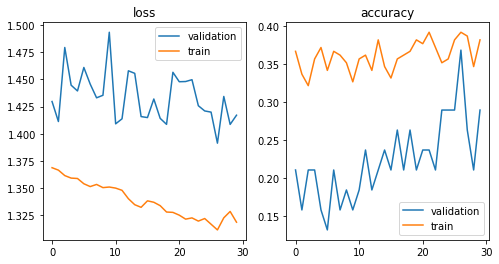

In [4]:
class RNN_LSTM(nn.Module):
    def __init__(self, input_size=22, hidden_size=64, num_layers=2, num_classes=4):
        super(RNN_LSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Dim: batch_size, time, feature
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True,dropout = 0.7)
        self.fc = nn.Sequential(
                    nn.Linear(hidden_size, num_classes),
                    
        )
        

    def forward(self, x):

        # Forward propagate RNN
        out, _ = self.lstm(x)

        # Decode hidden state of last time step
        out = self.fc(out[:, -1, :])
        return out
    
    
    
import torch.autograd as autograd
import matplotlib.pyplot as plt

model = RNN_LSTM()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, betas=(0.9,0.999), eps=1e-08, weight_decay=0.005)
stats = {}
stats['train'] = []
stats['val']  = []

epoches = range(30)
for epoch in epoches:
    train(epoch)
    stats['train'].append(test(train_loader,mode = 'train'))
    stats['val'].append(test(val_loader,mode = 'val'))
    
    if epoch == epoches[-1]:
        test(test_loader,mode = 'test')

# draw a figure for this layer
stats['val']  = np.array(stats['val'])
stats['train'] = np.array(stats['train'])

fig, ax = plt.subplots(1, 2,figsize = (8,4))
ax[0].plot(epoches,stats['val'][:,0],epoches,stats['train'][:,0])

ax[0].legend(['validation','train'])
ax[0].set_title('loss')

ax[1].plot(epoches,stats['val'][:,1],epoches,stats['train'][:,1])

ax[1].legend(['validation','train'])
ax[1].set_title('accuracy')

## 2 layers lstm + 1 fc Dropout layers 

Train Epoch: 0 [0/199 (0%)]	Loss: 1.408329
Train Epoch: 0 [100/199 (50%)]	Loss: 1.404091
train loss: 1.3854, Accuracy: 56/199 (28%)

validation loss: 1.3865, Accuracy: 11/50 (22%)

Train Epoch: 1 [0/199 (0%)]	Loss: 1.380865
Train Epoch: 1 [100/199 (50%)]	Loss: 1.389568
train loss: 1.3816, Accuracy: 56/199 (28%)

validation loss: 1.3869, Accuracy: 16/50 (32%)

Train Epoch: 2 [0/199 (0%)]	Loss: 1.380248
Train Epoch: 2 [100/199 (50%)]	Loss: 1.389282
train loss: 1.3791, Accuracy: 59/199 (30%)

validation loss: 1.3886, Accuracy: 14/50 (28%)

Train Epoch: 3 [0/199 (0%)]	Loss: 1.368813
Train Epoch: 3 [100/199 (50%)]	Loss: 1.383849
train loss: 1.3763, Accuracy: 62/199 (31%)

validation loss: 1.3886, Accuracy: 13/50 (26%)

Train Epoch: 4 [0/199 (0%)]	Loss: 1.382856
Train Epoch: 4 [100/199 (50%)]	Loss: 1.391689
train loss: 1.3736, Accuracy: 64/199 (32%)

validation loss: 1.3906, Accuracy: 14/50 (28%)

Train Epoch: 5 [0/199 (0%)]	Loss: 1.355904
Train Epoch: 5 [100/199 (50%)]	Loss: 1.357959
train 

Text(0.5,1,'accuracy')

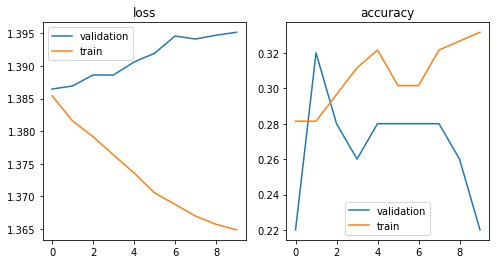

In [5]:
import torch.autograd as autograd
import matplotlib.pyplot as plt

class RNN_LSTM(nn.Module):
    def __init__(self, input_size=22, hidden_size=64, num_layers=2, num_classes=4):
        super(RNN_LSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Dim: batch_size, time, feature
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True,dropout = 0.5)
        self.fc = nn.Sequential(
                    nn.Dropout(p=0.5),
                    nn.Linear(hidden_size, 4),        
        )
        

    def forward(self, x):

        # Forward propagate RNN
        out, _ = self.lstm(x)

        # Decode hidden state of last time step
        out = self.fc(out[:, -1, :])
        return out
    


model = RNN_LSTM()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9,0.999), eps=1e-08, weight_decay=0.005)
stats = {}
stats['train'] = []
stats['val']  = []

epoches = range(10)
for epoch in epoches:
    train(epoch)
    stats['train'].append(test(train_loader,mode = 'train'))
    stats['val'].append(test(test_loader,mode = 'val'))

# draw a figure for this layer
stats['val']  = np.array(stats['val'])
stats['train'] = np.array(stats['train'])

fig, ax = plt.subplots(1, 2,figsize = (8,4))
ax[0].plot(epoches,stats['val'][:,0],epoches,stats['train'][:,0])

ax[0].legend(['validation','train'])
ax[0].set_title('loss')

ax[1].plot(epoches,stats['val'][:,1],epoches,stats['train'][:,1])

ax[1].legend(['validation','train'])
ax[1].set_title('accuracy')

## 2 layers lstm + more fc  layers 

Train Epoch: 0 [0/199 (0%)]	Loss: 1.422886
Train Epoch: 0 [100/199 (50%)]	Loss: 1.387501
train loss: 1.3872, Accuracy: 49/199 (25%)

validation loss: 1.3848, Accuracy: 13/50 (26%)

Train Epoch: 1 [0/199 (0%)]	Loss: 1.416835
Train Epoch: 1 [100/199 (50%)]	Loss: 1.386567
train loss: 1.3856, Accuracy: 49/199 (25%)

validation loss: 1.3840, Accuracy: 13/50 (26%)

Train Epoch: 2 [0/199 (0%)]	Loss: 1.400488
Train Epoch: 2 [100/199 (50%)]	Loss: 1.373263
train loss: 1.3842, Accuracy: 50/199 (25%)

validation loss: 1.3845, Accuracy: 12/50 (24%)

Train Epoch: 3 [0/199 (0%)]	Loss: 1.368259
Train Epoch: 3 [100/199 (50%)]	Loss: 1.378890
train loss: 1.3834, Accuracy: 54/199 (27%)

validation loss: 1.3847, Accuracy: 14/50 (28%)

Train Epoch: 4 [0/199 (0%)]	Loss: 1.378201
Train Epoch: 4 [100/199 (50%)]	Loss: 1.379593
train loss: 1.3822, Accuracy: 56/199 (28%)

validation loss: 1.3848, Accuracy: 14/50 (28%)

Train Epoch: 5 [0/199 (0%)]	Loss: 1.392063
Train Epoch: 5 [100/199 (50%)]	Loss: 1.366790
train 

Text(0.5,1,'accuracy')

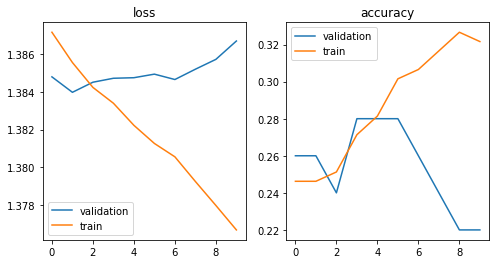

In [7]:
import torch.autograd as autograd
import matplotlib.pyplot as plt

class RNN_LSTM(nn.Module):
    def __init__(self, input_size=22, hidden_size=64, num_layers=2, num_classes=4):
        super(RNN_LSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Dim: batch_size, time, feature
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True,dropout = 0.5)
        self.fc = nn.Sequential(
                    nn.Dropout(p=0.5),
                    nn.Linear(hidden_size, 64),
                    nn.ReLU(inplace=True),
                    nn.Linear(hidden_size, 4),  

        )
        

    def forward(self, x):

        # Forward propagate RNN
        out, _ = self.lstm(x)

        # Decode hidden state of last time step
        out = self.fc(out[:, -1, :])
        return out
    


model = RNN_LSTM()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9,0.999), eps=1e-08, weight_decay=0.005)
stats = {}
stats['train'] = []
stats['val']  = []

epoches = range(10)
for epoch in epoches:
    train(epoch)
    stats['train'].append(test(train_loader,mode = 'train'))
    stats['val'].append(test(test_loader,mode = 'val'))

# draw a figure for this layer
stats['val']  = np.array(stats['val'])
stats['train'] = np.array(stats['train'])

fig, ax = plt.subplots(1, 2,figsize = (8,4))
ax[0].plot(epoches,stats['val'][:,0],epoches,stats['train'][:,0])

ax[0].legend(['validation','train'])
ax[0].set_title('loss')

ax[1].plot(epoches,stats['val'][:,1],epoches,stats['train'][:,1])

ax[1].legend(['validation','train'])
ax[1].set_title('accuracy')

## 2 layer GRU + 1fc

Train Epoch: 0 [0/199 (0%)]	Loss: 1.381482
Train Epoch: 0 [100/199 (50%)]	Loss: 1.382322
train loss: 1.3741, Accuracy: 60/199 (30%)

validation loss: 1.3902, Accuracy: 15/50 (30%)

Train Epoch: 1 [0/199 (0%)]	Loss: 1.392781
Train Epoch: 1 [100/199 (50%)]	Loss: 1.400099
train loss: 1.3660, Accuracy: 72/199 (36%)

validation loss: 1.4103, Accuracy: 13/50 (26%)

Train Epoch: 2 [0/199 (0%)]	Loss: 1.385284
Train Epoch: 2 [100/199 (50%)]	Loss: 1.338520
train loss: 1.3641, Accuracy: 70/199 (35%)

validation loss: 1.4216, Accuracy: 13/50 (26%)

Train Epoch: 3 [0/199 (0%)]	Loss: 1.387743
Train Epoch: 3 [100/199 (50%)]	Loss: 1.332576
train loss: 1.3594, Accuracy: 75/199 (38%)

validation loss: 1.4141, Accuracy: 14/50 (28%)

Train Epoch: 4 [0/199 (0%)]	Loss: 1.377054
Train Epoch: 4 [100/199 (50%)]	Loss: 1.372416
train loss: 1.3566, Accuracy: 70/199 (35%)

validation loss: 1.4036, Accuracy: 13/50 (26%)

Train Epoch: 5 [0/199 (0%)]	Loss: 1.341459
Train Epoch: 5 [100/199 (50%)]	Loss: 1.368775
train 

Text(0.5,1,'accuracy')

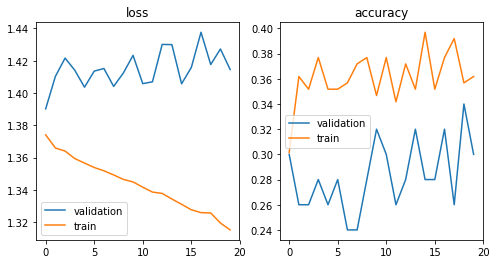

In [9]:
import torch.autograd as autograd
import matplotlib.pyplot as plt

class RNN_LSTM(nn.Module):
    def __init__(self, input_size=22, hidden_size=64, num_layers=2, num_classes=4):
        super(RNN_LSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Dim: batch_size, time, feature
        self.lstm = nn.GRU(input_size, hidden_size, num_layers,
                            batch_first=True,dropout = 0.5)
        self.fc = nn.Sequential(
#                     nn.Dropout(p=0.5),
#                     nn.Linear(hidden_size, 64),
#                     nn.ReLU(inplace=True),
                    nn.Linear(hidden_size, 4),  

        )
        

    def forward(self, x):

        # Forward propagate RNN
        out, _ = self.lstm(x)

        # Decode hidden state of last time step
        out = self.fc(out[:, -1, :])
        return out
    


model = RNN_LSTM()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9,0.999), eps=1e-08, weight_decay=0.005)
stats = {}
stats['train'] = []
stats['val']  = []

epoches = range(20)
for epoch in epoches:
    train(epoch)
    stats['train'].append(test(train_loader,mode = 'train'))
    stats['val'].append(test(test_loader,mode = 'val'))

# draw a figure for this layer
stats['val']  = np.array(stats['val'])
stats['train'] = np.array(stats['train'])

fig, ax = plt.subplots(1, 2,figsize = (8,4))
ax[0].plot(epoches,stats['val'][:,0],epoches,stats['train'][:,0])

ax[0].legend(['validation','train'])
ax[0].set_title('loss')

ax[1].plot(epoches,stats['val'][:,1],epoches,stats['train'][:,1])

ax[1].legend(['validation','train'])
ax[1].set_title('accuracy')